## Preparação do ambiente
Primeiro precisamos instalar nossa biblioteca. Eu recomendo utilizar o
ambiente do Google Colab porque não necessita preocupação com set up, além de rodar em um ambiente virtual.

In [1]:
!pip install prophet

Agora precisamos importar as dependências. Alguns pacotes aqui são fundamentais como o pandas, numpy e Prophet, mas recomendo você importar todas caso preciso trabalhar na formatação e plotagem de gráficos e análises.


In [79]:
import pandas as pd
import numpy as np
from prophet import Prophet
# bibliotecas para trabalhar offline com a biblioteca
import plotly
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go # criará de fato os gráficos
from plotly.offline import plot, iplot
import cufflinks as cf # para conectar o plotly ao pandas
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
import plotly.io as pio
pio.renderers
pio.renderers.default = 'colab'
import warnings
warnings.simplefilter("ignore")
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

Eu sugiro você preparar sua base de dados e disponibilizar em uma pasta do Google Drive.
Para ter acesso, você precisa permitir que o colab acesse sua pasta.

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Agora vamos importar nosso dataset usando o método do pandas pd.read.
Você especificar o formato do arquivo e seu respectivo endereço

In [98]:
df=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Temperature_Forecast/Registros_de_Temperatura_e_umidade_2012.xlsx")

## Tratamento dos dados
Vamos dá uma olhada nos dados importadas usando o metodo do pandas .head(). O objetivo aqui é ter uma idea geral dos dados e iniciar o tratamento de valores ausentes, valores duplicados, transformar o tipo, eliminar colunas etc.

In [99]:
df.head()

,ID,Data/Hora,Temperatura [°C],Umidade [%Hr],ds,y
0,1,2013-03-01 13:00:00,26.3,61.7,2013-03-01 13:00:00.288,26.3
1,2,2013-03-01 14:00:00,27.0,59.9,2013-03-01 13:59:59.712,27.0
2,3,2013-03-01 15:00:00,26.8,61.9,2013-03-01 15:00:00.000,26.8
3,4,2013-03-01 16:00:00,26.1,64.4,2013-03-01 16:00:00.288,26.1
4,5,2013-03-01 17:00:00,25.1,65.1,2013-03-01 16:59:59.712,25.1


In [100]:
#esta função descrever as principais estatisticas de cada coluna. Eu optei por passar o parametro "all", mas você pode eleiminar //
#este item para ficar mais simples a visualização das colunas com valores numéricos
display(df.describe(include="all"))

,ID,Data/Hora,Temperatura [°C],Umidade [%Hr],ds,y
count,313.00000,313,313.00000,313.000000,313,313.00000
unique,NaN,313,NaN,NaN,313,NaN
top,NaN,2013-03-01 13:00:00,NaN,NaN,2013-03-01 13:00:00.288000,NaN
freq,NaN,1,NaN,NaN,1,NaN
first,NaN,2013-03-01 13:00:00,NaN,NaN,2013-03-01 13:00:00.288000,NaN
last,NaN,2013-03-14 13:00:00,NaN,NaN,2013-03-14 13:00:00.288000,NaN
mean,157.00000,NaN,24.87476,74.225559,NaN,24.87476
std,90.49954,NaN,1.81236,7.596211,NaN,1.81236
min,1.00000,NaN,21.90000,51.700000,NaN,21.90000
25%,79.00000,NaN,23.40000,69.700000,NaN,23.40000


In [84]:
#Esta função avalia se existem valores nulos e % de valores nulos em cada coluna. Em datasets com um percentual de valores //
#ausentes muito alto pode comprometer o resultado dos modelos

df.isnull().sum() / df.shape[0] * 100



ID                  0.0
Data/Hora           0.0
Temperatura [°C]    0.0
Umidade [%Hr]       0.0
ds                  0.0
y                   0.0
dtype: float64

In [ ]:
#df.isnull().sum()
#se você quiser ver a quantidade de dados ausentes apenas

In [85]:
#Esta função avalia se existem linhas com valores duplicados em nosso dataset
df.duplicated().sum()

0

## Visualização gráfica
Aqui buscamos as relações e comportamentos gerais de nossos dados

<Axes: xlabel='Temperatura [°C]', ylabel='Density'>

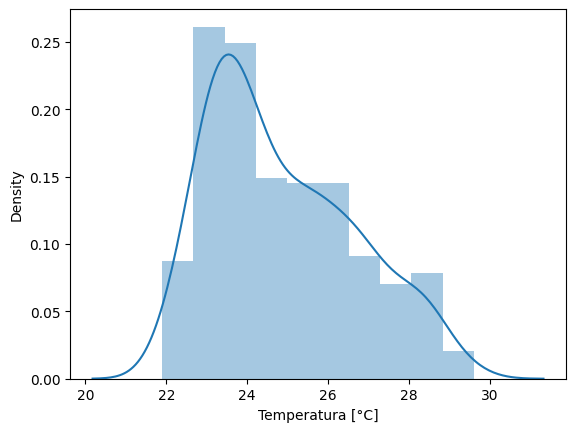

In [86]:
#Vamos plotar um histograma para visualizar a distribuição da temperatura
sns.distplot(df["Temperatura [°C]"], bins=10)


In [87]:
#observe a variação que a temperatura em todo o período variou entre os valores abaixo:
print(df["Temperatura [°C]"].min())
print(df["Temperatura [°C]"].max())

21.9
29.6


<Axes: xlabel='Umidade [%Hr]', ylabel='Density'>

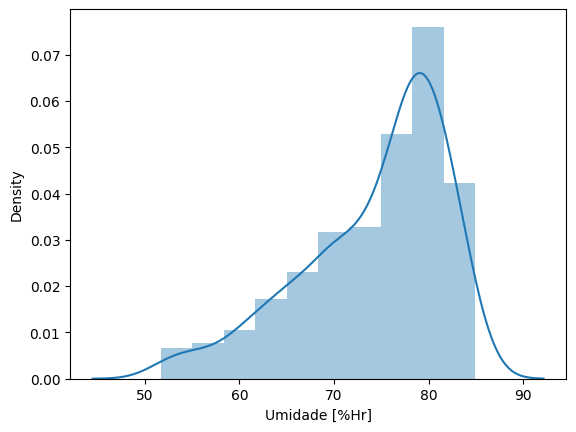

In [88]:
#Vamos plotar um histograma para visualizar a distribuição da Umidade
sns.distplot(df["Umidade [%Hr]"], bins=10)

In [89]:
#observe a variação que a Umidade relativa em todo o período variou entre os valores abaixo:
print(df["Umidade [%Hr]"].min())
print(df["Umidade [%Hr]"].max())

51.7
84.9


<Axes: xlabel='Temperatura [°C]', ylabel='Umidade [%Hr]'>

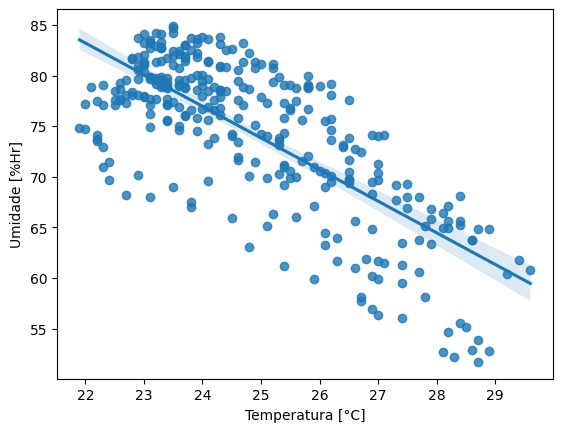

In [101]:
# como estamos tratando com 2 variaveis que se comportam ao logo do tempo, vamos avaliar a correlação entre elas //
#pra isso vamos plotar em um scatterplot e incluir outros paramentros como o ci= confidence interval e fit regression para //
#traçar a linha que melhor trata a correlação entre a temperatura e umidade. a banda sobreada é o intervalo de confiança dessa linha

# Visualmente dá para identificar se a temperatura aumenta a umidade cai, o que significa dizer que têm uma correlação negativa.

sns.regplot(x="Temperatura [°C]", y="Umidade [%Hr]", data=df, scatter=True, ci=95, fit_reg=True)

In [103]:
# Calcule a correlação entre as duas colunas
#A temperatura aumenta a umidade cai, o que significa dizer que têm uma correlação negativa; esse valor é dado abaixo
# essa correlação é de aproximadamente ~75% neste nosso exemplo

correlacao = df['Temperatura [°C]'].corr(df['Umidade [%Hr]'])
print(correlacao)

-0.7458521527867024


<Axes: xlabel='Data/Hora'>

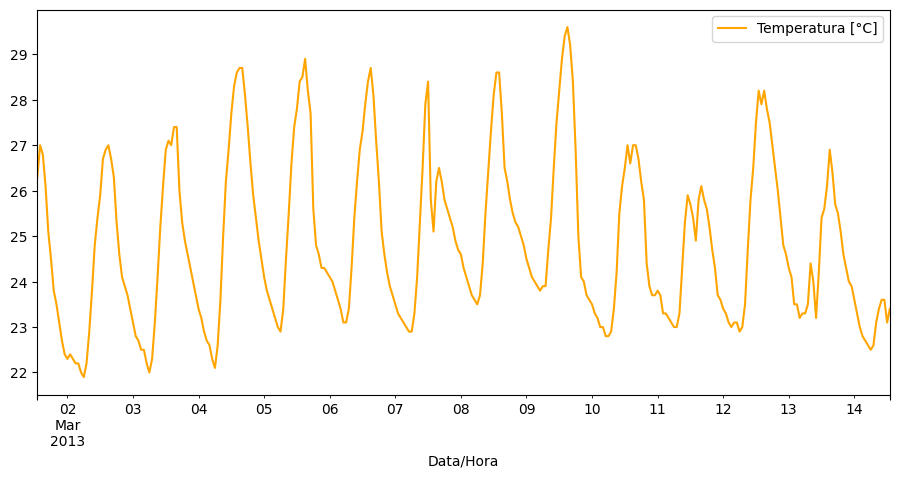

In [102]:
# Vamos avaliar o comportamneto dos dados ao longo do tempo
#A temperatura temperatura  e Umidade se comportam de maneira sazonal ao longo de cada se repetindo em ciclos de baixa-alta-baixa ao longo das 24 horas
df.plot(kind="line",x="Data/Hora", y='Temperatura [°C]', figsize=(11,5), color="orange")

<Axes: xlabel='Data/Hora'>

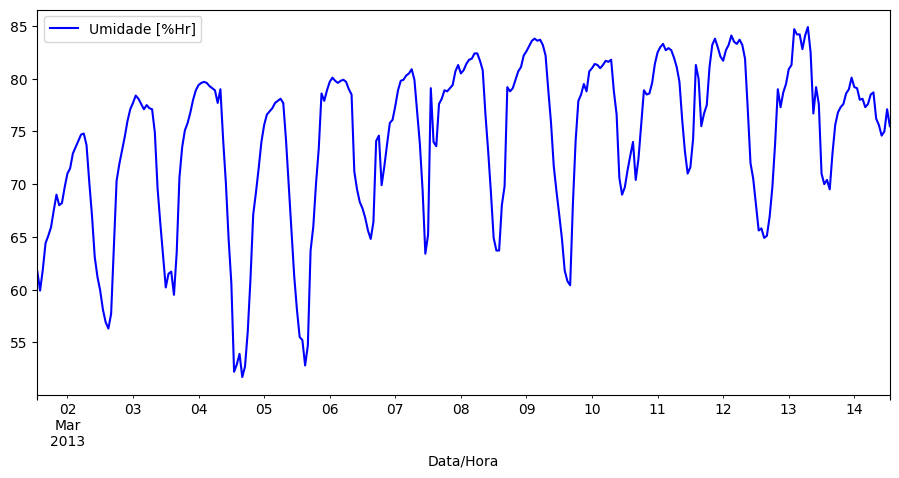

In [104]:
df.plot(kind="line",x="Data/Hora", y='Umidade [%Hr]', figsize=(11,5), color="blue")

## Preparando o modelo

Para checar a estacionariedadade da serie existem 2 metodos que normalmente são
Metodo #1: Plotar o gráfico como fizemos acima
Metodo #2: plotar os graficos ACF e PACF

O Prophet, desenvolvido pelo Facebook, é um modelo de previsão de séries temporais que é capaz de lidar com séries temporais não estacionárias. Uma das vantagens do Prophet é que ele **não exige que a série temporal seja estacionária** antes da modelagem. Portanto, não é um pressuposto estrito que a série seja estacionária ao usar o Prophet.

Entretanto, **é sempre uma boa prática examinar a série temporal** para entender suas características antes de aplicar qualquer modelo. A análise exploratória dos dados pode revelar tendências, padrões sazonais, ou outras características que podem influenciar o desempenho do modelo.

Se houver sazonalidade ou tendências óbvias na série, o Prophet geralmente consegue capturar esses padrões automaticamente, sem a necessidade de diferenciação ou transformações manuais. **Dito isso, em alguns casos, pode ser benéfico aplicar diferenciação ou transformações para melhorar a estacionariedade da série temporal**, especialmente se existirem padrões que o modelo não consegue capturar adequadamente. No nosso caso vamos apenas avaliar a estacionariedade por meio do teste AD Fuller.

In [105]:
from statsmodels.tsa.stattools import adfuller

# Execute o teste ADF com o nível de significância personalizado
result = adfuller(df['Temperatura [°C]'])
# Defina o nível de significância (alpha)
nivel_de_significancia = 0.05

# Analise o valor-p (p-value) no resultado
valor_p = result[1]

# Verifique se a série é estacionária com base no valor-p
if valor_p < nivel_de_significancia:
    print("A série é estacionária.")
    print(f'p-value: {result[1]}')
else:
    print("A série não é estacionária.")

A série é estacionária.
p-value: 0.011587581548796232


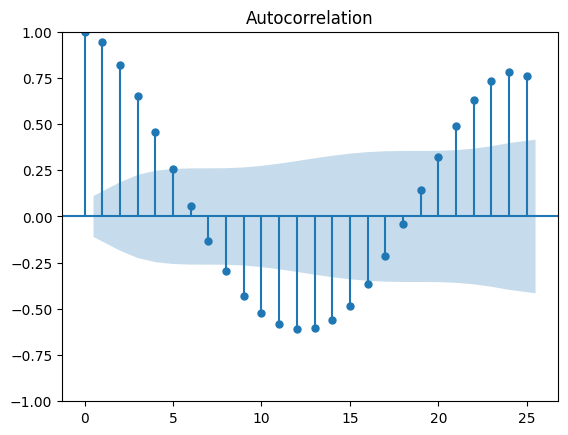

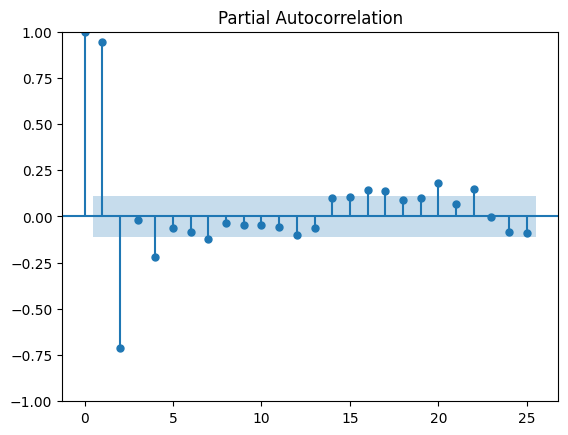

In [106]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(df['Temperatura [°C]'])

pacf = plot_pacf(df['Temperatura [°C]'])

# Transformando a variável umidade em estacionaria.
Não necessitamos fazer, mas optei por demosntrar aqui porque no mundo real a maioria das séries temporais são não estacionárias.

In [107]:
#from statsmodels.tsa.stattools import adfuller

# Execute o teste ADF com o nível de significância personalizado
#result1 = adfuller(df['Umidade [%Hr]'])
# Defina o nível de significância (alpha)
#nivel_de_significancia = 0.05

# Analise o valor-p (p-value) no resultado
#valor_p = result1[1]

# Verifique se a série é estacionária com base no valor-p
#if valor_p < nivel_de_significancia:
 #   print("A série é estacionária.")
  #  print(f'p-value: {result1[1]}')
#else:
 #   print("A série não é estacionária.")

In [108]:
#df=df.diff().dropna()
#df.plot(kind="line",x="Data/Hora", y='Umidade [%Hr]', figsize=(11,5), color="blue")

In [110]:
#from statsmodels.tsa.stattools import adfuller

# Execute o teste ADF com o nível de significância personalizado
#result2 = adfuller(df['Umidade [%Hr]'])
# Defina o nível de significância (alpha)
#nivel_de_significancia = 0.05

# Analise o valor-p (p-value) no resultado
#valor_p = result2[1]

# Verifique se a série é estacionária com base no valor-p
#if valor_p < nivel_de_significancia:
 #   print("A série é estacionária.")
   # print(f'p-value: {result2[1]}')
#else:
 #   print("A série não é estacionária.")

In [111]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#acf = plot_acf(df['Umidade [%Hr]'])

#pacf = plot_pacf(df['Umidade [%Hr]'])

O Prophet,  é projetado para facilitar a modelagem e previsão de séries temporais univariadas, ou seja, séries temporais que consistem em uma única variável ao longo do tempo. No nosso caso a hora e temperatura.
O modelo utiliza duas colunas obrigatórias no DataFrame de entrada:

1. **ds (Data):** Esta coluna contém as datas correspondentes às observações da série temporal.

2. **y (Observação):** Esta coluna contém os valores observados da série temporal correspondentes às datas.

Além dessas colunas obrigatórias, o Prophet também permite a inclusão de colunas adicionais que representam feriados ou outros eventos sazonais que podem influenciar a série temporal.

Por isso, vamos eleiminar as colunas não necessárias e manter em nosso modelo as colunas com os nomes ds para as datas e y para a temperatura.

In [112]:
df1= df.drop(["ID","Data/Hora","Temperatura [°C]","Umidade [%Hr]"], axis=1)

In [113]:
df1

,ds,y
0,2013-03-01 13:00:00.288,26.3
1,2013-03-01 13:59:59.712,27.0
2,2013-03-01 15:00:00.000,26.8
3,2013-03-01 16:00:00.288,26.1
4,2013-03-01 16:59:59.712,25.1
...,...,...
308,2013-03-14 09:00:00.000,23.4
309,2013-03-14 10:00:00.288,23.6
310,2013-03-14 10:59:59.712,23.6
311,2013-03-14 12:00:00.000,23.1


In [114]:
df1.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [115]:
#Observe que a coluna ds já está como tipo datetime e para analise de series temporais isso é imprescidível. Neste caso não precisamos, mas
# quando não temps esta configuração precisariamos transformar para o tipo datetime64[ns]
df1["ds"]=pd.to_datetime(df["ds"])


In [116]:
#setar como sequencia indexada a coluna que tem a variável de tempo
df1.set_index("ds", drop=True, inplace=True)

In [117]:
#indexação das linhas
df1.index

DatetimeIndex(['2013-03-01 13:00:00.288000', '2013-03-01 13:59:59.712000',
                      '2013-03-01 15:00:00', '2013-03-01 16:00:00.288000',
               '2013-03-01 16:59:59.712000',        '2013-03-01 18:00:00',
               '2013-03-01 19:00:00.288000', '2013-03-01 19:59:59.712000',
                      '2013-03-01 21:00:00', '2013-03-01 22:00:00.288000',
               ...
               '2013-03-14 04:00:00.288000', '2013-03-14 04:59:59.712000',
                      '2013-03-14 06:00:00', '2013-03-14 07:00:00.288000',
               '2013-03-14 07:59:59.712000',        '2013-03-14 09:00:00',
               '2013-03-14 10:00:00.288000', '2013-03-14 10:59:59.712000',
                      '2013-03-14 12:00:00', '2013-03-14 13:00:00.288000'],
              dtype='datetime64[ns]', name='ds', length=313, freq=None)

In [118]:
#Classificação em ordem crescente
df1.sort_index(axis=0, ascending=True)

,y
ds,
2013-03-01 13:00:00.288,26.3
2013-03-01 13:59:59.712,27.0
2013-03-01 15:00:00.000,26.8
2013-03-01 16:00:00.288,26.1
2013-03-01 16:59:59.712,25.1
...,...
2013-03-14 09:00:00.000,23.4
2013-03-14 10:00:00.288,23.6
2013-03-14 10:59:59.712,23.6


In [119]:
df1.max()

y    29.6
dtype: float64

## Training Model

O parâmetro** `changepoint_range` refere-se à proporção dos dados nos quais o modelo permitirá automaticamente identificar potenciais pontos de mudança (changepoints) na série temporal.

O valor padrão para `changepoint_range` é 0.9, o que significa que o modelo considerará os primeiros 90% dos dados para procurar potenciais changepoints. Isso é feito para evitar que o modelo se ajuste demais a pequenas flutuações no final da série temporal, que podem não ser representativas do comportamento geral.


- Um valor mais alto (por exemplo, 0.9) tornará o modelo mais flexível, permitindo que ele se ajuste a mudanças em uma proporção maior dos dados.

Ao ajustar o valor do `changepoint_range`, você está basicamente controlando quão sensível o modelo deve ser às mudanças na tendência.

 No entanto, também é importante evitar overfitting, pois valores muito altos podem levar a um ajuste excessivo aos dados de treinamento.

 O parâmetro daily_seasonality quando é definido como True, o modelo considera padrões sazonais diários ao ajustar a tendência da série temporal.

Ao habilitar a sazonalidade diária, o Prophet tentará capturar variações que ocorrem em um ciclo diário. Isso é particularmente útil quando se trabalha com dados que exibem padrões ou comportamentos específicos em diferentes momentos do dia.

O parâmetro interval_width no Prophet controla a largura do intervalo de confiança para as previsões geradas pelo modelo. Especificamente, ele determina a porcentagem da distribuição de incertezas associada à previsão que será incluída nos intervalos de confiança.

Quando interval_width é definido como 0.95 (o valor padrão), significa que o intervalo de confiança para as previsões incluirá 95% da distribuição de incertezas. Em outras palavras, o intervalo de confiança abrange a faixa na qual o modelo acredita que a verdadeira observação tem 95% de probabilidade de estar.

In [120]:
m=Prophet (interval_width=0.95,  daily_seasonality=True, changepoint_range= 0.9)
model=m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24iin_83/pz_brsg4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp24iin_83/dazxpmv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97748', 'data', 'file=/tmp/tmp24iin_83/pz_brsg4.json', 'init=/tmp/tmp24iin_83/dazxpmv_.json', 'output', 'file=/tmp/tmp24iin_83/prophet_model8tru_09m/prophet_model-20231117103013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:30:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:30:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Prediction

In [121]:
#Estamos definindo 24 periodos ou no nosso caso 24 horas no futuro para fazer a predição
# o parametro cap é devido ao maior valor que esperamos, no nosso caso a maior temperatura ficou abaixo de 30° C, isso foi//
# definido apenas para ficar melhor a visualização gráfica
# Quero visualizar os 24 valores preditos, e por isso defini o metodo forecast.head(25) para visualizar na ultima coluna todos os valores previstos
future=m.make_future_dataframe(periods=24, freq="H")
df['cap'] = 30

future['cap'] = 30

forecast=m.predict(future)
forecast.head(25)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-03-01 13:00:00.288,23.607184,30,24.540144,27.199832,23.607184,23.607184,2.254707,2.254707,2.254707,2.254707,2.254707,2.254707,0.0,0.0,0.0,25.861891
1,2013-03-01 13:59:59.712,23.628567,30,24.954526,27.483273,23.628567,23.628567,2.524375,2.524375,2.524375,2.524375,2.524375,2.524375,0.0,0.0,0.0,26.152942
2,2013-03-01 15:00:00.000,23.649956,30,24.932339,27.693325,23.649956,23.649956,2.617606,2.617606,2.617606,2.617606,2.617606,2.617606,0.0,0.0,0.0,26.267562
3,2013-03-01 16:00:00.288,23.671344,30,24.720169,27.362461,23.671344,23.671344,2.405519,2.405519,2.405519,2.405519,2.405519,2.405519,0.0,0.0,0.0,26.076863
4,2013-03-01 16:59:59.712,23.692728,30,24.258991,26.784331,23.692728,23.692728,1.854043,1.854043,1.854043,1.854043,1.854043,1.854043,0.0,0.0,0.0,25.546770
5,2013-03-01 18:00:00.000,23.714116,30,23.579547,26.031106,23.714116,23.714116,1.097912,1.097912,1.097912,1.097912,1.097912,1.097912,0.0,0.0,0.0,24.812028
6,2013-03-01 19:00:00.288,23.735505,30,22.745159,25.430972,23.735505,23.735505,0.369982,0.369982,0.369982,0.369982,0.369982,0.369982,0.0,0.0,0.0,24.105487
7,2013-03-01 19:59:59.712,23.756888,30,22.383649,24.822212,23.756888,23.756888,-0.158879,-0.158879,-0.158879,-0.158879,-0.158879,-0.158879,0.0,0.0,0.0,23.598009
8,2013-03-01 21:00:00.000,23.778276,30,21.862356,24.556655,23.778276,23.778276,-0.480483,-0.480483,-0.480483,-0.480483,-0.480483,-0.480483,0.0,0.0,0.0,23.297793
9,2013-03-01 22:00:00.288,23.799665,30,21.794354,24.422462,23.799665,23.799665,-0.707633,-0.707633,-0.707633,-0.707633,-0.707633,-0.707633,0.0,0.0,0.0,23.092032


In [122]:
# Estamos definindo os valores de preditos pelo algoritmo na etapa de treino e os valores futuros em uma unica base
forecast[["ds", "yhat"]]

,ds,yhat
0,2013-03-01 13:00:00.288,25.861891
1,2013-03-01 13:59:59.712,26.152942
2,2013-03-01 15:00:00.000,26.267562
3,2013-03-01 16:00:00.288,26.076863
4,2013-03-01 16:59:59.712,25.546770
...,...,...
332,2013-03-15 09:00:00.288,22.765865
333,2013-03-15 10:00:00.288,23.623403
334,2013-03-15 11:00:00.288,24.296023
335,2013-03-15 12:00:00.288,24.760927


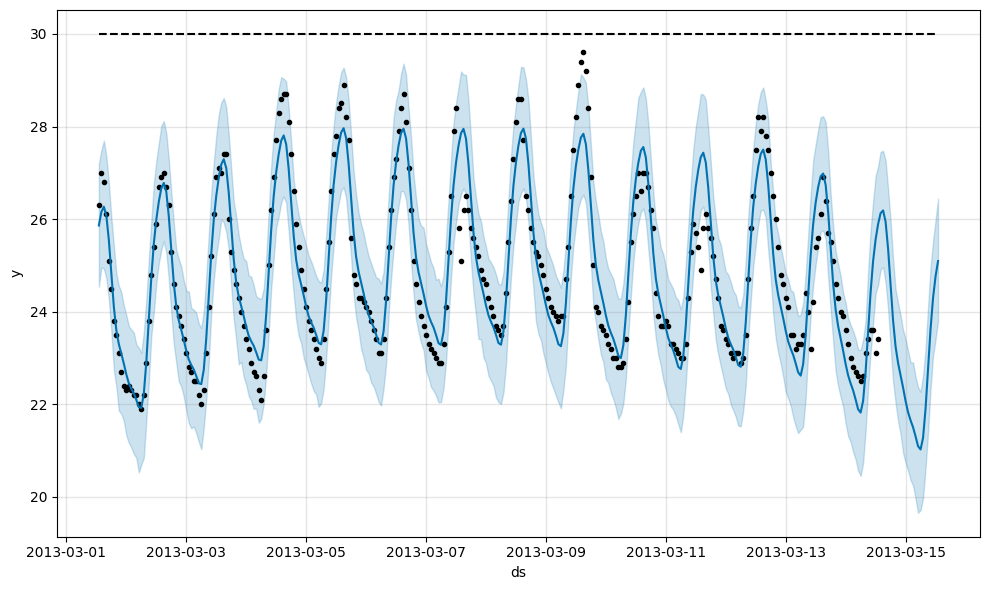

In [123]:
# plotamos os valores de preditos pelo algoritmo na etapa de treino e os valores futuros ecom a banda de intervalo de confiança sombreada
plot1=m.plot(forecast)

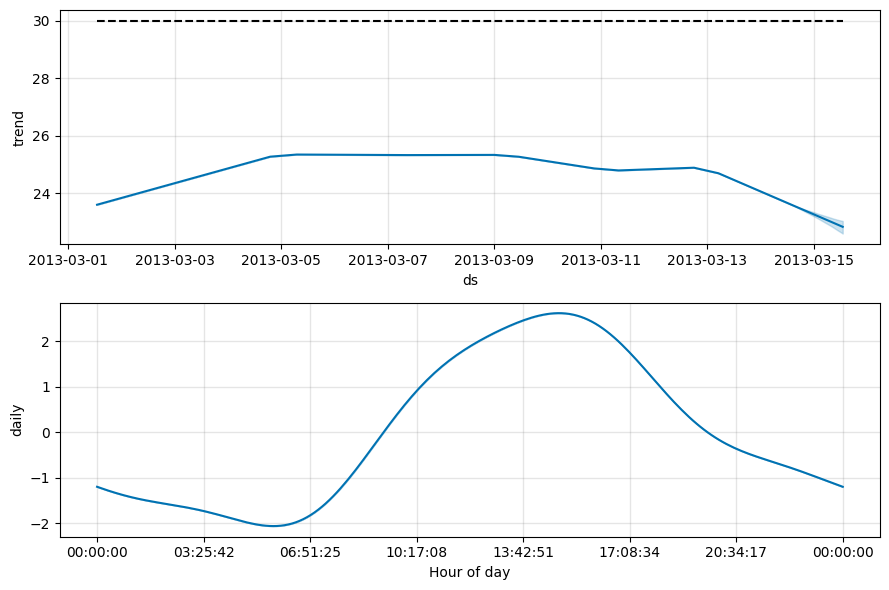

In [124]:
plot2=m.plot_components(forecast)

Em séries temporais, "changepoints" (pontos de mudança) referem-se a momentos específicos no tempo onde a tendência da série temporal experimenta uma mudança significativa. Os changepoints são pontos onde a direção ou a inclinação da tendência da série temporal se altera. No contexto do modelo Prophet, os changepoints são utilizados para capturar potenciais mudanças na trajetória da série temporal.

O Prophet, permite que você especifique manualmente esses changepoints ou pode optar por permitir que o modelo **os escolha automaticamente**.

Changepoints são usados para modelar mudanças na tendência da série temporal. Eles podem ajudar o modelo a se adaptar a eventos ou padrões não sazonais que causam alterações notáveis na trajetória temporal.

Um maior número de changepoints tornará o modelo mais flexível, mas também pode aumentar o risco de overfitting (ajuste excessivo) aos dados de treinamento.

Enquanto o Prophet é projetado para lidar automaticamente com padrões sazonais, como feriados e efeitos diários/semanais, os changepoints são mais úteis para capturar mudanças na tendência que não são explicadas pela sazonalidade.

Neste trecho, optei por mostrar visualmente essas mudanças plotando os pontos de mudanças de tendencia.

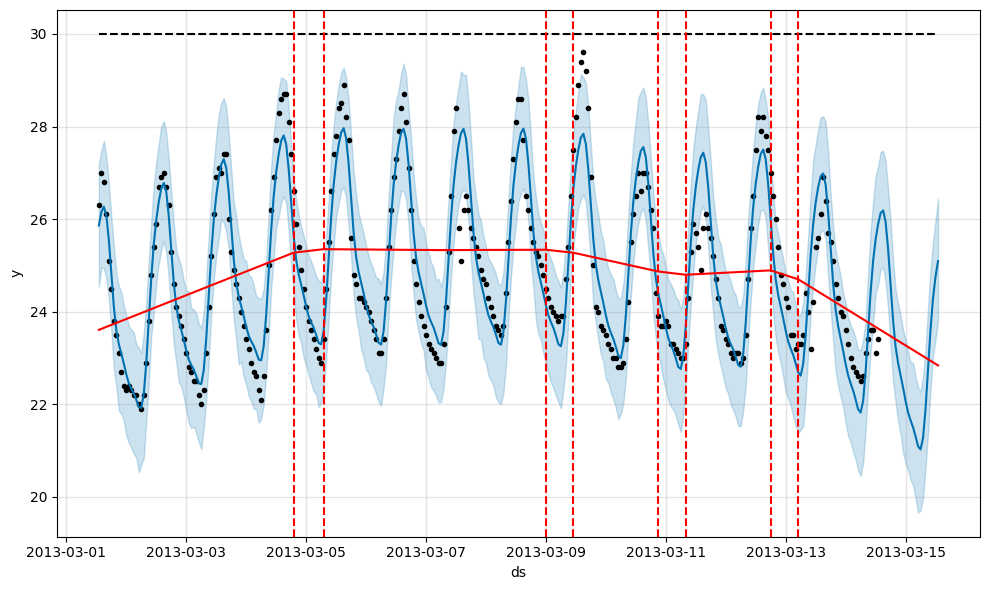

In [125]:
#Observe que do inicio até a primeira linha vertical vermelha vinha em um tendência de alta e apartir desse ponto o movimento perdeu força//
# e a partir na segunda linha vertical a tendencia torna-se horizontal e segue sucessivamente mudando ao longo do tempo, conforme a linha horizontal vermelha mostra
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [126]:
print(forecast)

                         ds      trend  cap  yhat_lower  yhat_upper  \
0   2013-03-01 13:00:00.288  23.607184   30   24.540144   27.199832   
1   2013-03-01 13:59:59.712  23.628567   30   24.954526   27.483273   
2   2013-03-01 15:00:00.000  23.649956   30   24.932339   27.693325   
3   2013-03-01 16:00:00.288  23.671344   30   24.720169   27.362461   
4   2013-03-01 16:59:59.712  23.692728   30   24.258991   26.784331   
..                      ...        ...  ...         ...         ...   
332 2013-03-15 09:00:00.288  22.972111   30   21.384047   24.096952   
333 2013-03-15 10:00:00.288  22.938885   30   22.328867   24.948947   
334 2013-03-15 11:00:00.288  22.905660   30   23.045331   25.523907   
335 2013-03-15 12:00:00.288  22.872434   30   23.401957   25.976844   
336 2013-03-15 13:00:00.288  22.839209   30   23.797535   26.441791   

     trend_lower  trend_upper  additive_terms  additive_terms_lower  \
0      23.607184    23.607184        2.254707              2.254707   
1    